<a href="https://colab.research.google.com/github/danjethh/audio_forensics/blob/main/audio_forensic_using_ai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 🔍 Project Overview: Detecting Tampered Audio Using Unsupervised Learning

In forensic investigations, audio recordings are often used as evidence—but verifying their authenticity can be challenging. Subtle edits like splices, removals, or sampling changes may go unnoticed using traditional signal analysis methods.

This project explores how **unsupervised machine learning** can assist in detecting **tampered audio recordings** using only basic features such as `Duration (ss)` and `Sample Rate (Hz)`. Since real-world tampered data is scarce or unlabeled, we apply an unsupervised anomaly detection model—**Isolation Forest**—to learn the normal structure of untampered audio and flag unusual patterns.

By using this lightweight approach, forensic investigators can:
- Automatically screen audio for irregularities
- Operate without labeled tampered examples
- Scale detection to large volumes of recordings

The walkthrough below demonstrates how we clean the dataset, train the model, and analyze a new suspicious audio file.


## Step 1: Load and Preview the Raw Audio Dataset

### Purpose  
Load the original dataset of untampered (clean) audio recordings to verify that each row contains **numerical measurements (features)** describing a single audio file.

### Input  
- A direct GitHub link to the `.csv.xls` dataset file.

### Output  
- Displays the **first 10 rows** of the dataset in a table.  
- Lists all **column names**, each representing a distinct audio feature (e.g., pitch, duration, sample rate).

### Description  
This step ensures the dataset is accessible and gives users a clear overview of the raw structure and contents before any cleaning or modeling.


In [1]:
# Step 1: Load and Display Dataset Details
def load_audio_dataset():
    import pandas as pd

    # GitHub raw link to the dataset
    url = "https://raw.githubusercontent.com/danjethh/audio_forensics/main/Values.csv"

    # Load the dataset
    df = pd.read_csv(url, encoding='latin1', engine='python', on_bad_lines='skip')

    # Print dataset info
    print("Dataset loaded successfully.")
    print(f"Total rows: {df.shape[0]}")
    print(f"Total columns: {df.shape[1]}")
    print("\nFirst 10 rows:")

    display(df.head(10))

    return df

# Call the function
df = load_audio_dataset()


Dataset loaded successfully.
Total rows: 614
Total columns: 27

First 10 rows:


,File Name,Duration (ss),Fundamental Frequency (Hz),Mean Pitch (Hz),Pitch Sigma (Hz),Minimum Pitch (Hz),Maximum Pitch (Hz),No. of Pulses,No. of periods,Mean Period (ss),...,Peak Amplitude Channel 1 (dB),Peak Amplitude Channel 2 (dB),Bit Rate (kbs),Sample Rate (Hz),Resolution (bits),No of Samples,Size on memory (kB),Size on disk (MB),Channels,Source
0,speaker1_00,60.030000,155.449136,155.449,40.954,76.401,595.867,4458,4319,6.46E-03,...,-2.08,-7.02,1536.0,48000,16,2880000,307.46,1.37,stereo,htt://en.m.wikipedia.org/wiki/Holi
1,speaker1_01,60.030000,148.55562,148.556,34.376,78.64,581.55,4030,3914,6.73E-03,...,-4.6,-10.31,1536.0,48000,16,2880000,307.46,1.37,stereo,htt://en.m.wikipedia.org/wiki/Holi
2,speaker1_02,60.030000,145.306523,145.307,38.117,74.808,553.119,4024,3893,6.91E-03,...,-3.65,-7.97,1536.0,48000,16,2880000,307.46,1.37,stereo,htt://en.m.wikipedia.org/wiki/Holi
3,speaker1_03,60.030000,147.912099,147.912,36.828,68.095,589.918,4116,3994,6.79E-03,...,-5.65,-7.96,1536.0,48000,16,2880000,307.46,1.37,stereo,htt://en.m.wikipedia.org/wiki/Holi
4,speaker1_04,60.030000,150.163581,150.164,35.449,77.557,557.195,3624,3507,6.68E-03,...,-3.26,-6.45,1536.0,48000,16,2880000,307.46,1.37,stereo,htt://en.m.wikipedia.org/wiki/Holi
5,speaker1_05,60.034979,147.447288,147.447,42.173,69.238,559.534,4018,3903,6.82E-03,...,-4.98,-9.2,1536.0,48000,16,2880000,307.46,1.37,stereo,htt://en.m.wikipedia.org/wiki/Holi
6,speaker1_06,60.034979,138.428902,138.429,37.552,76.718,596.054,3647,3525,7.26E-03,...,-5.03,-6.23,1536.0,48000,16,2880000,307.46,1.37,stereo,htt://en.m.wikipedia.org/wiki/Holi
7,speaker1_07,60.034979,128.484654,128.485,26.264,78.682,411.371,3691,3572,7.81E-03,...,-6.08,-8.62,1536.0,48000,16,2880000,307.46,1.37,stereo,htt://en.m.wikipedia.org/wiki/Holi
8,speaker1_08,60.034979,143.929268,143.929,43.185,75.88,596.639,3711,3575,6.98E-03,...,-4.61,-6.45,1536.0,48000,16,2880000,307.46,1.37,stereo,htt://en.m.wikipedia.org/wiki/Holi
9,speaker1_09,60.034979,136.31225,136.312,43.315,76.46,585.347,3845,3718,7.38E-03,...,-7.73,-8.52,1536.0,48000,16,2880000,307.46,1.37,stereo,htt://en.m.wikipedia.org/wiki/Holi


## Step 2: Clean Raw Dataset and Select Relevant Features for Training

### Purpose  
Filter out irrelevant columns and retain only the essential features required for model training—specifically `Duration (ss)` and `Sample Rate (Hz)`.

### Input  
- The raw dataset loaded in Step 1.

### Output  
- A cleaned table containing only `Duration (ss)` and `Sample Rate (Hz)` columns.  
- A saved file named `cleaned_audio_dataset.csv`.  
- Displays the first 10 rows of the cleaned dataset.

### Description  
After cleaning and selecting the relevant features, the resulting dataset becomes the **training dataset**. These two features were chosen because they are simple to extract and sufficient for this lightweight anomaly detection task.


In [2]:
# Step 2: Clean Raw Dataset and Select Relevant Features as Training Dataset
def clean_and_select_features(df):
    import pandas as pd

    # Select only the features also extractable using librosa
    target_columns = [
        "Duration (ss)",
        "Sample Rate (Hz)"
    ]

    # Filter only those columns
    df_clean = df[target_columns].copy()

    # Convert to numeric (if needed)
    df_clean = df_clean.apply(pd.to_numeric, errors='coerce')

    # Show NaN info before dropping rows
    print("Missing values per column before dropping rows:")
    print(df_clean.isna().sum())

    # Drop any rows with missing values
    df_clean = df_clean.dropna()

    # Save cleaned dataset
    df_clean.to_csv("cleaned_audio_dataset.csv", index=False)

    # Summary
    print("\nData cleaned and saved as 'cleaned_audio_dataset.csv'")
    print(f"Rows retained: {df_clean.shape[0]}")
    print(f"Columns retained: {df_clean.shape[1]}")
    display(df_clean.head(10))

    return df_clean

# Call the function
df_features = clean_and_select_features(df)


Missing values per column before dropping rows:
Duration (ss)       0
Sample Rate (Hz)    0
dtype: int64

Data cleaned and saved as 'cleaned_audio_dataset.csv'
Rows retained: 614
Columns retained: 2


,Duration (ss),Sample Rate (Hz)
0,60.030000,48000
1,60.030000,48000
2,60.030000,48000
3,60.030000,48000
4,60.030000,48000
5,60.034979,48000
6,60.034979,48000
7,60.034979,48000
8,60.034979,48000
9,60.034979,48000


## Step 3: Train Model Using the Training Dataset

### Purpose  
Train an Isolation Forest model on the cleaned dataset so it can learn the statistical patterns of untampered audio recordings and detect outliers.

### Input  
- The training dataset containing only `Duration (ss)` and `Sample Rate (Hz)` for each audio file.

### Output  
- A trained Isolation Forest model capable of detecting anomalous audio.  
- A table showing each audio file’s anomaly status (`1` for normal, `-1` for outlier).  
- Displays the first 10 rows of the prediction results.

### Description  
This step enables the model to establish a baseline of normal behavior using simple acoustic features. Audio recordings that significantly deviate from this baseline will later be flagged as potential anomalies.


In [3]:
# Step 3: Train Isolation Forest and Save the Model
def train_and_save_isolation_forest(df_features):
    from sklearn.ensemble import IsolationForest
    import joblib

    # Initialize and train the Isolation Forest model
    model = IsolationForest(n_estimators=100, contamination='auto', random_state=42)
    model.fit(df_features)

    # Predict anomalies
    predictions = model.predict(df_features)

    # Store predictions in the dataframe
    df_results = df_features.copy()
    df_results["Anomaly"] = predictions

    # Save the trained model
    joblib.dump(model, "audio_isolation_forest_model.pkl")
    print("Model trained and saved as 'audio_isolation_forest_model.pkl'.")

    # Show basic stats
    anomaly_count = (df_results["Anomaly"] == -1).sum()
    print(f"Total rows in training set: {df_results.shape[0]}")
    print(f"Number of predicted anomalies (outliers): {anomaly_count}")
    display(df_results.head(10))

    return model, df_results

# Call the function
model, df_results = train_and_save_isolation_forest(df_features)


Model trained and saved as 'audio_isolation_forest_model.pkl'.
Total rows in training set: 614
Number of predicted anomalies (outliers): 183


,Duration (ss),Sample Rate (Hz),Anomaly
0,60.030000,48000,1
1,60.030000,48000,1
2,60.030000,48000,1
3,60.030000,48000,1
4,60.030000,48000,1
5,60.034979,48000,1
6,60.034979,48000,1
7,60.034979,48000,1
8,60.034979,48000,1
9,60.034979,48000,1


## Step 4: Visualize Anomaly Prediction Results

### Purpose  
Provide a visual summary of how the trained model classified the audio files—whether as normal or anomalous—based on the feature patterns learned during training.

### Input  
- The prediction results generated by the Isolation Forest model in Step 3.

### Output  
- A bar chart showing the count of audio files labeled as normal (`1`) versus anomalous (`-1`).

### Description  
This step helps interpret the model's behavior by visualizing the distribution of its predictions. It allows for a quick assessment of whether the model is too sensitive (flagging too many outliers) or too lenient (missing anomalies).


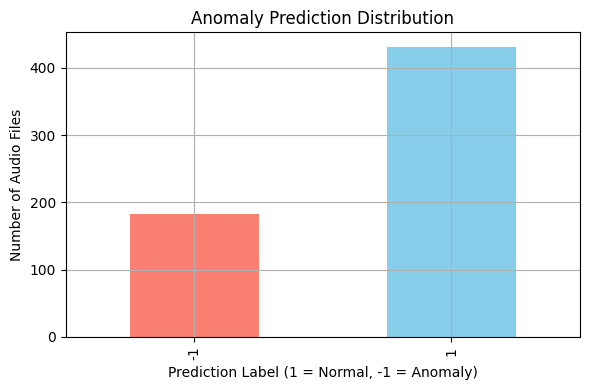

In [4]:
# Step 4: Visualize Anomaly Prediction Distribution
def plot_anomaly_distribution(df_results):
    import matplotlib.pyplot as plt

    # Count how many normal and anomalous predictions
    anomaly_counts = df_results["Anomaly"].value_counts().sort_index()

    # Plot
    plt.figure(figsize=(6, 4))
    anomaly_counts.plot(kind='bar', color=['salmon', 'skyblue'])
    plt.title("Anomaly Prediction Distribution")
    plt.xlabel("Prediction Label (1 = Normal, -1 = Anomaly)")
    plt.ylabel("Number of Audio Files")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Call the function
plot_anomaly_distribution(df_results)


## Step 5: Extract Features from a Suspicious Audio File

### Purpose  
Extract the same features used during training—`Duration (ss)` and `Sample Rate (Hz)`—from a new audio file so it can be analyzed by the trained model.

### Input  
- A direct GitHub raw link to a `.wav` audio file.

### Output  
- A table showing the extracted values:
  - `Duration (ss)`
  - `Sample Rate (Hz)`

### Description  
This step ensures consistency between training and inference by using the same feature extraction method. The extracted values will be passed to the model to determine whether the audio is normal or anomalous.


In [5]:
# Step 5: Load audio from GitHub and extract matching features only
def extract_features_from_github_audio(github_raw_audio_url):
    import librosa
    import numpy as np
    import pandas as pd
    import urllib.request
    import os

    # Temporary filename
    local_filename = "temp_audio.wav"

    # Download the audio file
    urllib.request.urlretrieve(github_raw_audio_url, local_filename)

    # Load audio
    y, sr = librosa.load(local_filename, sr=None)

    # Extract only the features used during model training
    features = {
        "Duration (ss)": librosa.get_duration(y=y, sr=sr),
        "Sample Rate (Hz)": sr
    }

    # Create a DataFrame
    df_input = pd.DataFrame([features])

    print("Extracted features (Duration and Sample Rate) from GitHub-hosted audio file:")
    display(df_input)

    # Clean up
    os.remove(local_filename)

    return df_input

# Example usage
github_audio_url = "https://github.com/pdx-cs-sound/wavs/raw/main/car-horn.wav"
new_audio_features = extract_features_from_github_audio(github_audio_url)


Extracted features (Duration and Sample Rate) from GitHub-hosted audio file:


,Duration (ss),Sample Rate (Hz)
0,5.891583,48000


## Step 6: Predict Whether the Audio is Anomalous

### Purpose  
Use the trained Isolation Forest model to determine whether the extracted features from a new audio file indicate potential tampering or match the pattern of untampered audio.

### Input  
- A table containing the extracted features: `Duration (ss)` and `Sample Rate (Hz)`  
- The saved model file (`audio_isolation_forest_model.pkl`) from Step 3

### Output  
- A table showing the extracted features and a new `Anomaly` column:
  - `1` = Normal (untampered)
  - `-1` = Anomalous (possibly tampered)  
- A printed interpretation of the result in plain language.

### Description  
This step applies the trained model to real-world use: flagging suspicious audio. If the file’s features significantly deviate from what the model learned as normal, it will be labeled as anomalous and flagged for further investigation.


In [6]:
# Step 6: Use Saved Model to Predict if Uploaded Audio is Anomalous
def score_extracted_audio_features(model_path, extracted_features_df):
    import joblib

    # Load the saved Isolation Forest model
    model = joblib.load(model_path)

    # Predict anomaly status
    prediction = model.predict(extracted_features_df)

    # Add prediction result
    result = extracted_features_df.copy()
    result["Anomaly"] = prediction

    # Display results
    print("Prediction result for the uploaded audio:")
    display(result)

    # Print interpretation
    if prediction[0] == -1:
        print("The model flagged this audio as ANOMALOUS (possibly tampered).")
    else:
        print("The model flagged this audio as NORMAL (no anomalies detected).")

    return result

# Call the function with the extracted features
final_prediction = score_extracted_audio_features(
    model_path="audio_isolation_forest_model.pkl",
    extracted_features_df=new_audio_features
)


Prediction result for the uploaded audio:


,Duration (ss),Sample Rate (Hz),Anomaly
0,5.891583,48000,-1


The model flagged this audio as ANOMALOUS (possibly tampered).
